In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 31 11:42:46 2024

@author: venkatesh
"""

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np

/home/venkatesh/anaconda3/envs/venkatesh_pytorch_updated_110/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
model_name='SqueezeNet'

num_classes = 4
# Assuming 3 classes: "NORMAL", "DRUSEN", "DME","CNV"

if(model_name=='mobilenetv2'):
    from models.mobilenet import MobileNet2
    model=MobileNet2(in_channels=1, num_classes=4)
if(model_name=='ResNet50'):
    from models.resnet import ResNet50
    model=ResNet50(num_classes=num_classes, channels=1)    
if(model_name=='ShuffleNet2'):
    from models.ShuffleNet2 import ShuffleNet2
    model=ShuffleNet2(num_classes=num_classes,num_inp_channels=1)    
if(model_name=='SqueezeNet'):
    from models.SqueezeNet import SqueezeNet
    model=SqueezeNet(num_classes=num_classes,num_inp_channels=1)

In [4]:
model=model.to(device)


In [5]:
from datetime import datetime
import time

import os
print ('*******************************************************')
start_time=time.time()
experiments_folder="saved_models/"
experiment_name=datetime.now().strftime("%b_%d_%I_%M_%P_")+"_model_"+model_name

directory=experiments_folder+"/"+experiment_name+"/"
print(directory)
print('Model will be saved to  :', directory)

try:
    os.makedirs(directory)
except:
    print('model already existed..........')

*******************************************************
saved_models//Aug_01_11_08_pm__model_SqueezeNet/
Model will be saved to  : saved_models//Aug_01_11_08_pm__model_SqueezeNet/


In [6]:
import torchvision.transforms as transforms

# Define transformations for data augmentation or normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to required size
    transforms.ToTensor()
])

In [7]:
from dataset import CustomDataset
from torch.utils.data import Dataset, DataLoader

# Create CustomDataset instance
dataset = CustomDataset('./csv_files/data_train.csv', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset('./csv_files/data_valid.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(train_loader))
print(len(val_dataloader))

print('number of testing images',len(test_dataset))


2166
271
number of testing images 86648


In [8]:


learning_rate=0.0001
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train your model
# Train your model
from tqdm import tqdm

# Define your training function
model.train()
train_losses = []  # List to store training losses
val_losses = []  # List to store validaion losses
train_accuracy=[]
validation_accuracy=[]

num_epochs=25



for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss=0.0
    
    y_true_train = []
    y_pred_train = []


    # Create tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        #print(torch.unique(images))
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        y_pred_train.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})

        
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    train_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, running_loss))
    print("Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
        
    save_path=directory+'/mymodel_'+str(epoch)+'.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at: {save_path}')

    # storing the train losses
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    y_true_val = []
    y_pred_val = []

    
    model.eval()
    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

        y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_val.extend(labels.detach().tolist())

        
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Validation Loss': validation_loss / (batch_idx + 1)})

    # storing the validation losses

    epoch_loss = validation_loss / len(val_dataloader)
    val_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
    total = len(y_true_val)
    accuracy = total_correct * 100 / total
    validation_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Val mean loss: {:.8f}".format(epoch, validation_loss))
    print("valiation Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

    import pandas as pd

    loss_dic={"training_loss":train_losses,
              "val_loss":val_losses,
              "train_accuracy":train_accuracy,
              "validation_accuracy":validation_accuracy}

    df = pd.DataFrame.from_dict(loss_dic) 
    path=directory+'/loss.csv'
    df.to_csv (path, index = False, header=True)

Epoch 1/25: 100%|██████████| 2166/2166 [02:38<00:00, 13.69it/s, Loss=0.61] 


-------------------------------------------------
Epoch: 0 Train mean loss: 1322.26850940
Train Accuracy%:  79.16666666666667 == 13718 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_0.pth
Epoch [1/25], Loss: 0.6105


Epoch 1/25: 100%|██████████| 271/271 [00:11<00:00, 24.51it/s, Validation Loss=0.412]


Epoch [1/25], Loss: 0.4115
-------------------------------------------------
Epoch: 0 Val mean loss: 111.52505518
valiation Accuracy%:  85.41762805722196 == 1851 / 2167
-------------------------------------------------


Epoch 2/25: 100%|██████████| 2166/2166 [02:35<00:00, 13.97it/s, Loss=0.481]


-------------------------------------------------
Epoch: 1 Train mean loss: 1042.26034524
Train Accuracy%:  84.10087719298245 == 14573 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_1.pth
Epoch [2/25], Loss: 0.4812


Epoch 2/25: 100%|██████████| 271/271 [00:11<00:00, 24.34it/s, Validation Loss=0.371]


Epoch [2/25], Loss: 0.3706
-------------------------------------------------
Epoch: 1 Val mean loss: 100.43942639
valiation Accuracy%:  88.23257960313798 == 1912 / 2167
-------------------------------------------------


Epoch 3/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.15it/s, Loss=0.334]


-------------------------------------------------
Epoch: 2 Train mean loss: 724.22543695
Train Accuracy%:  88.90235457063712 == 15405 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_2.pth
Epoch [3/25], Loss: 0.3344


Epoch 3/25: 100%|██████████| 271/271 [00:11<00:00, 24.45it/s, Validation Loss=0.283]


Epoch [3/25], Loss: 0.2828
-------------------------------------------------
Epoch: 2 Val mean loss: 76.64145800
valiation Accuracy%:  92.15505306875865 == 1997 / 2167
-------------------------------------------------


Epoch 4/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.02it/s, Loss=0.251]


-------------------------------------------------
Epoch: 3 Train mean loss: 544.07227970
Train Accuracy%:  92.01869806094183 == 15945 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_3.pth
Epoch [4/25], Loss: 0.2512


Epoch 4/25: 100%|██████████| 271/271 [00:11<00:00, 24.49it/s, Validation Loss=0.202]


Epoch [4/25], Loss: 0.2015
-------------------------------------------------
Epoch: 3 Val mean loss: 54.61648500
valiation Accuracy%:  93.4010152284264 == 2024 / 2167
-------------------------------------------------


Epoch 5/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.04it/s, Loss=0.206]


-------------------------------------------------
Epoch: 4 Train mean loss: 446.65934320
Train Accuracy%:  93.44990766389658 == 16193 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_4.pth
Epoch [5/25], Loss: 0.2062


Epoch 5/25: 100%|██████████| 271/271 [00:11<00:00, 24.43it/s, Validation Loss=0.195]


Epoch [5/25], Loss: 0.1953
-------------------------------------------------
Epoch: 4 Val mean loss: 52.92999118
valiation Accuracy%:  93.63174896169821 == 2029 / 2167
-------------------------------------------------


Epoch 6/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.00it/s, Loss=0.181]


-------------------------------------------------
Epoch: 5 Train mean loss: 391.79028288
Train Accuracy%:  94.11934441366574 == 16309 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_5.pth
Epoch [6/25], Loss: 0.1809


Epoch 6/25: 100%|██████████| 271/271 [00:11<00:00, 24.23it/s, Validation Loss=0.202]


Epoch [6/25], Loss: 0.2020
-------------------------------------------------
Epoch: 5 Val mean loss: 54.73282675
valiation Accuracy%:  94.13936317489618 == 2040 / 2167
-------------------------------------------------


Epoch 7/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.00it/s, Loss=0.161]


-------------------------------------------------
Epoch: 6 Train mean loss: 347.81099772
Train Accuracy%:  94.84649122807018 == 16435 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_6.pth
Epoch [7/25], Loss: 0.1606


Epoch 7/25: 100%|██████████| 271/271 [00:11<00:00, 24.47it/s, Validation Loss=0.195]


Epoch [7/25], Loss: 0.1947
-------------------------------------------------
Epoch: 6 Val mean loss: 52.75121583
valiation Accuracy%:  94.27780341485925 == 2043 / 2167
-------------------------------------------------


Epoch 8/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.01it/s, Loss=0.151]


-------------------------------------------------
Epoch: 7 Train mean loss: 326.34786222
Train Accuracy%:  95.0657894736842 == 16473 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_7.pth
Epoch [8/25], Loss: 0.1507


Epoch 8/25: 100%|██████████| 271/271 [00:11<00:00, 24.56it/s, Validation Loss=0.171]


Epoch [8/25], Loss: 0.1706
-------------------------------------------------
Epoch: 7 Val mean loss: 46.24104514
valiation Accuracy%:  94.32395016151361 == 2044 / 2167
-------------------------------------------------


Epoch 9/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.04it/s, Loss=0.133]


-------------------------------------------------
Epoch: 8 Train mean loss: 288.40756773
Train Accuracy%:  95.85064635272391 == 16609 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_8.pth
Epoch [9/25], Loss: 0.1332


Epoch 9/25: 100%|██████████| 271/271 [00:11<00:00, 24.46it/s, Validation Loss=0.178]


Epoch [9/25], Loss: 0.1780
-------------------------------------------------
Epoch: 8 Val mean loss: 48.22901233
valiation Accuracy%:  94.37009690816798 == 2045 / 2167
-------------------------------------------------


Epoch 10/25: 100%|██████████| 2166/2166 [02:34<00:00, 14.03it/s, Loss=0.128]


-------------------------------------------------
Epoch: 9 Train mean loss: 277.75140340
Train Accuracy%:  95.91989843028624 == 16621 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_9.pth
Epoch [10/25], Loss: 0.1282


Epoch 10/25: 100%|██████████| 271/271 [00:11<00:00, 24.59it/s, Validation Loss=0.154]


Epoch [10/25], Loss: 0.1541
-------------------------------------------------
Epoch: 9 Val mean loss: 41.75052036
valiation Accuracy%:  95.10844485463775 == 2061 / 2167
-------------------------------------------------


Epoch 11/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.10it/s, Loss=0.111]


-------------------------------------------------
Epoch: 10 Train mean loss: 240.98502338
Train Accuracy%:  96.42774699907663 == 16709 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_10.pth
Epoch [11/25], Loss: 0.1113


Epoch 11/25: 100%|██████████| 271/271 [00:11<00:00, 24.52it/s, Validation Loss=0.185]


Epoch [11/25], Loss: 0.1849
-------------------------------------------------
Epoch: 10 Val mean loss: 50.09493459
valiation Accuracy%:  94.83156437471158 == 2055 / 2167
-------------------------------------------------


Epoch 12/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.15it/s, Loss=0.101] 


-------------------------------------------------
Epoch: 11 Train mean loss: 219.37190430
Train Accuracy%:  96.58356417359188 == 16736 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_11.pth
Epoch [12/25], Loss: 0.1013


Epoch 12/25: 100%|██████████| 271/271 [00:11<00:00, 24.60it/s, Validation Loss=0.153]


Epoch [12/25], Loss: 0.1533
-------------------------------------------------
Epoch: 11 Val mean loss: 41.53159516
valiation Accuracy%:  95.20073834794647 == 2063 / 2167
-------------------------------------------------


Epoch 13/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.13it/s, Loss=0.0938]


-------------------------------------------------
Epoch: 12 Train mean loss: 203.16872927
Train Accuracy%:  96.95867959372114 == 16801 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_12.pth
Epoch [13/25], Loss: 0.0938


Epoch 13/25: 100%|██████████| 271/271 [00:10<00:00, 24.75it/s, Validation Loss=0.17] 


Epoch [13/25], Loss: 0.1703
-------------------------------------------------
Epoch: 12 Val mean loss: 46.14704812
valiation Accuracy%:  94.4623904014767 == 2047 / 2167
-------------------------------------------------


Epoch 14/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.14it/s, Loss=0.0883]


-------------------------------------------------
Epoch: 13 Train mean loss: 191.20734974
Train Accuracy%:  97.32802400738689 == 16865 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_13.pth
Epoch [14/25], Loss: 0.0883


Epoch 14/25: 100%|██████████| 271/271 [00:10<00:00, 24.78it/s, Validation Loss=0.163]


Epoch [14/25], Loss: 0.1628
-------------------------------------------------
Epoch: 13 Val mean loss: 44.13147782
valiation Accuracy%:  95.06229810798338 == 2060 / 2167
-------------------------------------------------


Epoch 15/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.15it/s, Loss=0.0809]


-------------------------------------------------
Epoch: 14 Train mean loss: 175.12546663
Train Accuracy%:  97.3915050784857 == 16876 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_14.pth
Epoch [15/25], Loss: 0.0809


Epoch 15/25: 100%|██████████| 271/271 [00:10<00:00, 24.94it/s, Validation Loss=0.175]


Epoch [15/25], Loss: 0.1749
-------------------------------------------------
Epoch: 14 Val mean loss: 47.41097652
valiation Accuracy%:  94.18550992155053 == 2041 / 2167
-------------------------------------------------


Epoch 16/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.13it/s, Loss=0.0721]


-------------------------------------------------
Epoch: 15 Train mean loss: 156.19641793
Train Accuracy%:  97.73776546629732 == 16936 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_15.pth
Epoch [16/25], Loss: 0.0721


Epoch 16/25: 100%|██████████| 271/271 [00:10<00:00, 24.66it/s, Validation Loss=0.194]


Epoch [16/25], Loss: 0.1938
-------------------------------------------------
Epoch: 15 Val mean loss: 52.52237718
valiation Accuracy%:  94.4623904014767 == 2047 / 2167
-------------------------------------------------


Epoch 17/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.09it/s, Loss=0.0685]


-------------------------------------------------
Epoch: 16 Train mean loss: 148.31449019
Train Accuracy%:  97.77239150507849 == 16942 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_16.pth
Epoch [17/25], Loss: 0.0685


Epoch 17/25: 100%|██████████| 271/271 [00:10<00:00, 24.77it/s, Validation Loss=0.173]


Epoch [17/25], Loss: 0.1726
-------------------------------------------------
Epoch: 16 Val mean loss: 46.77282221
valiation Accuracy%:  94.9238578680203 == 2057 / 2167
-------------------------------------------------


Epoch 18/25: 100%|██████████| 2166/2166 [02:32<00:00, 14.16it/s, Loss=0.0615]


-------------------------------------------------
Epoch: 17 Train mean loss: 133.15853000
Train Accuracy%:  97.99746075715605 == 16981 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_17.pth
Epoch [18/25], Loss: 0.0615


Epoch 18/25: 100%|██████████| 271/271 [00:10<00:00, 24.71it/s, Validation Loss=0.183]


Epoch [18/25], Loss: 0.1830
-------------------------------------------------
Epoch: 17 Val mean loss: 49.59490537
valiation Accuracy%:  94.83156437471158 == 2055 / 2167
-------------------------------------------------


Epoch 19/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.14it/s, Loss=0.0601]


-------------------------------------------------
Epoch: 18 Train mean loss: 130.09517021
Train Accuracy%:  97.95706371191136 == 16974 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_18.pth
Epoch [19/25], Loss: 0.0601


Epoch 19/25: 100%|██████████| 271/271 [00:10<00:00, 24.82it/s, Validation Loss=0.201]


Epoch [19/25], Loss: 0.2007
-------------------------------------------------
Epoch: 18 Val mean loss: 54.38699255
valiation Accuracy%:  94.4623904014767 == 2047 / 2167
-------------------------------------------------


Epoch 20/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.09it/s, Loss=0.0547]


-------------------------------------------------
Epoch: 19 Train mean loss: 118.51839555
Train Accuracy%:  98.21675900277009 == 17019 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_19.pth
Epoch [20/25], Loss: 0.0547


Epoch 20/25: 100%|██████████| 271/271 [00:11<00:00, 24.60it/s, Validation Loss=0.199]


Epoch [20/25], Loss: 0.1993
-------------------------------------------------
Epoch: 19 Val mean loss: 54.00150944
valiation Accuracy%:  94.97000461467466 == 2058 / 2167
-------------------------------------------------


Epoch 21/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.12it/s, Loss=0.0531]


-------------------------------------------------
Epoch: 20 Train mean loss: 115.11255772
Train Accuracy%:  98.25138504155125 == 17025 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_20.pth
Epoch [21/25], Loss: 0.0531


Epoch 21/25: 100%|██████████| 271/271 [00:10<00:00, 24.64it/s, Validation Loss=0.181]


Epoch [21/25], Loss: 0.1814
-------------------------------------------------
Epoch: 20 Val mean loss: 49.16813783
valiation Accuracy%:  94.60083064143979 == 2050 / 2167
-------------------------------------------------


Epoch 22/25: 100%|██████████| 2166/2166 [02:32<00:00, 14.17it/s, Loss=0.0542]


-------------------------------------------------
Epoch: 21 Train mean loss: 117.42515135
Train Accuracy%:  98.24561403508773 == 17024 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_21.pth
Epoch [22/25], Loss: 0.0542


Epoch 22/25: 100%|██████████| 271/271 [00:10<00:00, 24.65it/s, Validation Loss=0.209] 


Epoch [22/25], Loss: 0.2089
-------------------------------------------------
Epoch: 21 Val mean loss: 56.60561408
valiation Accuracy%:  94.60083064143979 == 2050 / 2167
-------------------------------------------------


Epoch 23/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.14it/s, Loss=0.0464]


-------------------------------------------------
Epoch: 22 Train mean loss: 100.59270593
Train Accuracy%:  98.54570637119113 == 17076 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_22.pth
Epoch [23/25], Loss: 0.0464


Epoch 23/25: 100%|██████████| 271/271 [00:10<00:00, 24.82it/s, Validation Loss=0.203]


Epoch [23/25], Loss: 0.2027
-------------------------------------------------
Epoch: 22 Val mean loss: 54.94122726
valiation Accuracy%:  94.41624365482234 == 2046 / 2167
-------------------------------------------------


Epoch 24/25: 100%|██████████| 2166/2166 [02:33<00:00, 14.14it/s, Loss=0.0455]


-------------------------------------------------
Epoch: 23 Train mean loss: 98.59804313
Train Accuracy%:  98.4533702677747 == 17060 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_23.pth
Epoch [24/25], Loss: 0.0455


Epoch 24/25: 100%|██████████| 271/271 [00:10<00:00, 24.76it/s, Validation Loss=0.243]


Epoch [24/25], Loss: 0.2431
-------------------------------------------------
Epoch: 23 Val mean loss: 65.88454947
valiation Accuracy%:  94.9238578680203 == 2057 / 2167
-------------------------------------------------


Epoch 25/25: 100%|██████████| 2166/2166 [02:32<00:00, 14.16it/s, Loss=0.0495]


-------------------------------------------------
Epoch: 24 Train mean loss: 107.14661014
Train Accuracy%:  98.36680517082179 == 17045 / 17328
-------------------------------------------------
Model saved at: saved_models//Aug_01_11_08_pm__model_SqueezeNet//mymodel_24.pth
Epoch [25/25], Loss: 0.0495


Epoch 25/25: 100%|██████████| 271/271 [00:10<00:00, 24.73it/s, Validation Loss=0.199]

Epoch [25/25], Loss: 0.1990
-------------------------------------------------
Epoch: 24 Val mean loss: 53.93159738
valiation Accuracy%:  94.55468389478541 == 2049 / 2167
-------------------------------------------------


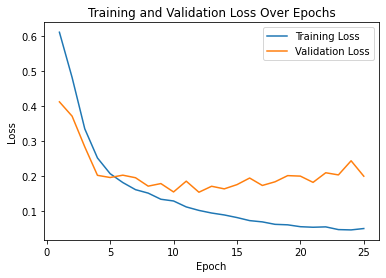

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

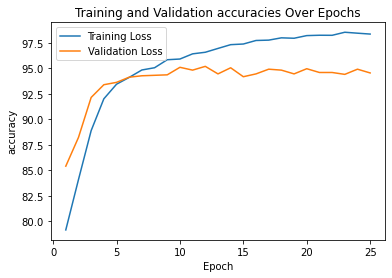

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Loss')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracies Over Epochs')
plt.legend()
plt.show()

# Model Analysis

In [12]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 224, 224]             960
       BatchNorm2d-2         [-1, 96, 224, 224]             192
              ReLU-3         [-1, 96, 224, 224]               0
         MaxPool2d-4         [-1, 96, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,552
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           1,088
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           9,280
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
             Fire-14        [-1, 128, 1

In [13]:
import re
from ptflops import get_model_complexity_info
from pthflops import count_ops

macs, params = get_model_complexity_info(model, (1, 224,224), as_strings=True,print_per_layer_stat=False, verbose=False)
# # Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

Computational complexity: 2.59 GMac
Computational complexity: 5.18 GFlops
Number of parameters: 730.18 k


# Testing 

In [14]:
# choosing the best model from validation loss.

best_epoch=np.argmin(val_losses)
print('best_epoch:',best_epoch)

best_epoch: 11


In [15]:
ckpt = torch.load(directory+'/mymodel_'+str(best_epoch)+'.pth')
model.load_state_dict(ckpt)
model.eval()


SqueezeNet(
  (stem): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fire2): Fire(
    (squeeze): Sequential(
      (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (expand_1x1): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (expand_3x3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )

In [16]:
from tqdm import tqdm

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(test_dataloader))

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f'testing')

y_true_val = []
y_pred_val = []


model.eval()
for batch_idx, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)
    #images=images/255
    optimizer.zero_grad()

    outputs = model(images)

    y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
    y_true_val.extend(labels.detach().tolist())



    # Update progress bar description with current loss



total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
total = len(y_true_val)
test_accuracy = total_correct * 100 / total

print("-------------------------------------------------")
print("TEST Accuracy (%): ", test_accuracy, "==", total_correct, "/", total)
print("-------------------------------------------------")


10831


testing: 100%|██████████| 10831/10831 [07:05<00:00, 25.44it/s]

-------------------------------------------------
TEST Accuracy (%):  95.09163512141076 == 82395 / 86648
-------------------------------------------------


In [22]:
import numpy as np 
from sklearn.metrics import confusion_matrix,classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt

In [25]:
cm = confusion_matrix(y_true_val,y_pred_val)

In [26]:
cm

array([[40287,   320,   193,    51],
       [  389,  5952,     9,   597],
       [  721,    70,  7842,   542],
       [  255,   833,   273, 28314]])

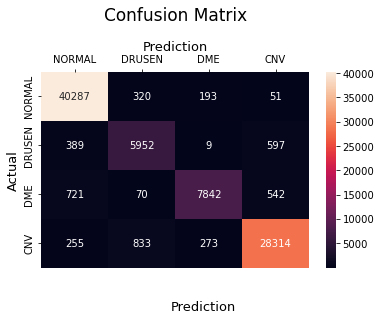

In [27]:
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=["NORMAL" , "DRUSEN", "DME" ,"CNV"],
            yticklabels=["NORMAL" , "DRUSEN", "DME" ,"CNV"])

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [17]:
test_accuracy_dic={"best epoch":[best_epoch],
          "test_accuracy":[test_accuracy]}

df = pd.DataFrame.from_dict(test_accuracy_dic) 
path=directory+'/test_accuracy.csv'
df.to_csv (path, index = False, header=True)

# Demo on Test data

[0, 0, 3, 2, 0, 3, 0, 0]
tensor([0, 0, 3, 2, 0, 3, 0, 0])


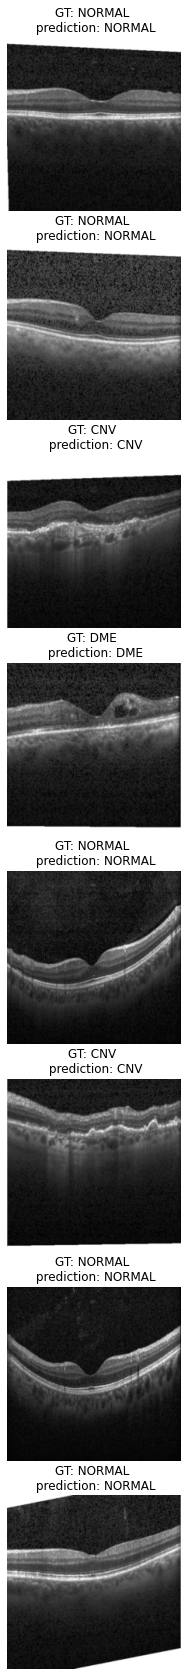

In [20]:
import matplotlib.pyplot as plt

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

int_to_class = {0:"NORMAL" , 1:"DRUSEN", 2:"DME" ,3:"CNV"}  
# Function to show images
def show_images(images, labels,predictions):
    plt.figure(figsize=(30, 30))
    for i in range(len(images)):
        plt.subplot(len(images),1 , i + 1)
        plt.title(f"GT: {int_to_class[labels[i].item()]} \n prediction: {int_to_class[predictions[i]]}")
        plt.imshow(images[i][0], cmap="gray")
        plt.axis('off')
    plt.show()

# Display a batch of images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    outputs_cpu=outputs.detach().argmax(dim=-1).tolist()
    print(outputs_cpu)
    print(labels)
    
    break  # Show only the first batch
    
    
images=images.to('cpu')
    
show_images(images,labels,outputs_cpu)